In [1]:
%matplotlib nbagg
import matplotlib.pyplot as plt
import time
import numpy as np

# load the qcodes path, until we have this installed as a package
import sys

qcpath = '/Users/alex/qdev/Qcodes'
if qcpath not in sys.path:
    sys.path.append(qcpath)

import qcodes as qc

qc.set_mp_method('spawn')  # force Windows behavior on mac

<IPython.core.display.Javascript object>

In [2]:
# spawn doesn't like function or class definitions in the interpreter
# session - had to move them to a file.
from toymodel import AModel, MockGates, MockSource, MockMeter, AverageGetter, AverageAndRaw

# no extra processes running yet
qc.active_children()

[]

In [3]:
# now create this "experiment"
model = AModel()
gates = MockGates('gates', model)
source = MockSource('source', model)
meter = MockMeter('meter', model)

station = qc.Station(gates, source, meter)

# could measure any number of things by adding arguments to this
# function call, but here we're just measuring one, the meter amplitude
station.set_measurement(meter.amplitude)

# it's nice to have the key parameters be part of the global namespace
# that way they're objects that we can easily set, get, and slice
# this could be simplified to a station method that gathers all parameters
# and adds them all as (disambiguated) globals, printing what it did
# something like:
#   station.gather_parameters(globals())
c0, c1, c2, vsd = gates.chan0, gates.chan1, gates.chan2, source.amplitude

# check that a DataServer is running (not yet implemented, but when we have
# a monitor, defining a station will start the DataServer to run the monitor)
qc.active_children()

[]

In [4]:
# we can get the measured quantities right now
station.measure()

[0.117]

In [5]:
# start a Loop (which by default runs in a seprarate process)
# the sweep values are defined by slicing the parameter object
# but more complicated sweeps (eg nonlinear, or adaptive) can
# easily be used instead
data = qc.Loop(c0[-20:20:0.1], 0.03).run(location='testsweep')

DataSet: DataMode.PULL_FROM_SERVER, location='testsweep'
   amplitude: amplitude
   chan0: chan0
started at 2016-01-15 12:00:48


In [6]:
# now there should be two extra processes running, DataServer and a sweep
qc.active_children()

[<DataServer-1, started daemon>, <MeasurementLoop-2, started daemon>]

In [7]:
# manually bring the data into the main process and display it as numbers
data.sync()
data.arrays

{'amplitude': DataArray[400]: amplitude
 array([ 0.117,  0.117,  0.115,  0.111,  0.106,  0.099,  0.092,    nan,
           nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,
           nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,
           nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,
           nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,
           nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,
           nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,
           nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,
           nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,
           nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,
           nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,
           nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,
           nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,
           nan,    nan, 

<IPython.core.display.Javascript object>


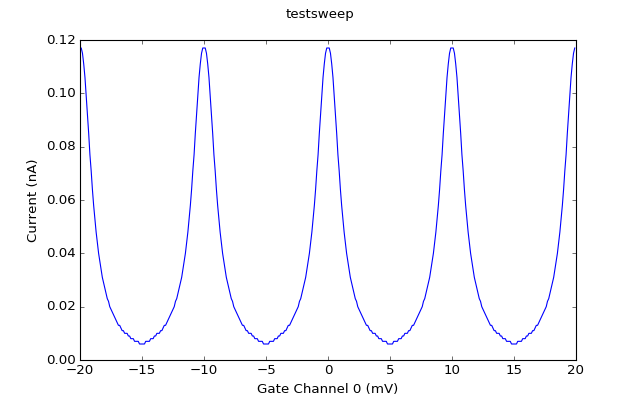

In [8]:
# live-updating plot, that syncs the data and stops updating when it's finished
plot = qc.Plot(data.amplitude)

DataSet: DataMode.PULL_FROM_SERVER, location='test2d'
   chan0: chan0
   chan1: chan1
   amplitude_3: amplitude
   amplitude_0: amplitude
started at 2016-01-15 12:01:05


<IPython.core.display.Javascript object>


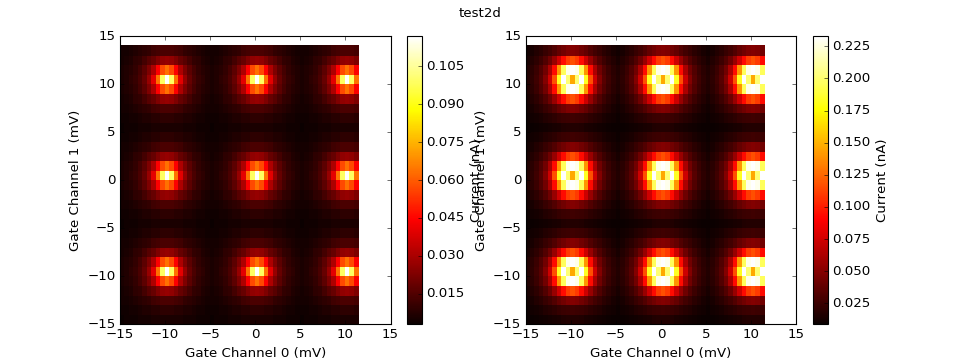

In [9]:
data2 = qc.Loop(c1[-15:15:1], 0.1).loop(c0[-15:12:.5], 0.01).each(
    meter.amplitude, # first measurement, at c2=0 -> amplitude_0 bcs it's action 0
    qc.Task(c2.set, 1), # action 1 -> c2.set(1)
    qc.Wait(0.001),
    meter.amplitude, # second measurement, at c2=1 -> amplitude_4 bcs it's action 4
    qc.Task(c2.set, 0)
    ).run(location='test2d')

# use the subplot and add features of qc.Plot
plot2 = qc.Plot(data2.amplitude_0, cmap=plt.cm.hot, figsize=(12, 4.5), subplots=(1, 2))
plot2.add(data2.amplitude_3, cmap=plt.cm.hot, subplot=2)

DataSet: DataMode.PULL_FROM_SERVER, location='test_multi_d'
   amplitude_5_0: amplitude
   amplitude_3_0: amplitude
   chan1: chan1
   chan2: chan2
   amplitude_2: amplitude
   chan0: chan0
   avg_amplitude: avg_amplitude
started at 2016-01-15 12:01:37


<IPython.core.display.Javascript object>


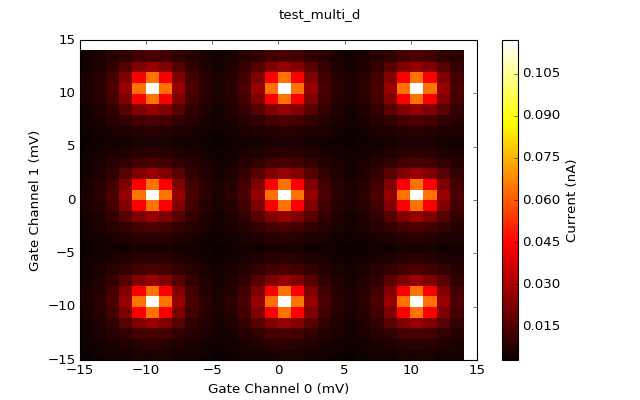

<IPython.core.display.Javascript object>


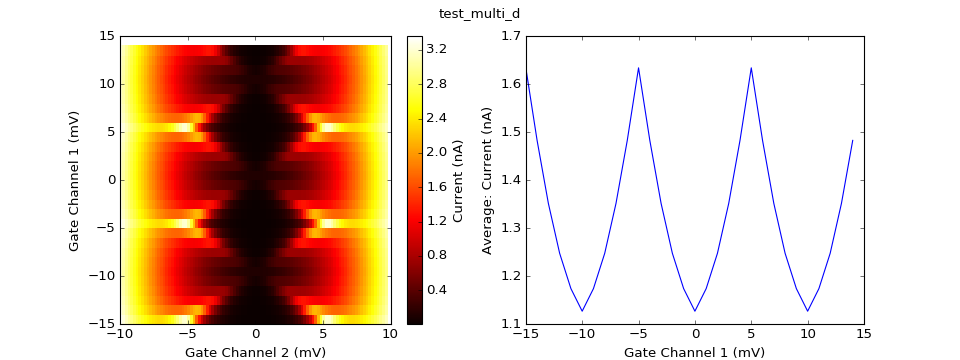

In [10]:
data3 = qc.Loop(c1[-15:15:1], 0.1).each(
    qc.Task(c0.set, -10),
    qc.Task(c2.set, 0),
    # a 1D measurement
    meter.amplitude,
    # a 2D sweep, .each is actually unnecessary bcs this is the default measurement
    qc.Loop(c0[-15:15:1], 0.001).each(meter.amplitude),
    qc.Task(c0.set, -10),
    # a 2D sweep with the same outer but different inner loop
    qc.Loop(c2[-10:10:0.2], 0.001),
    AverageGetter(meter.amplitude, c2[-10:10:0.2], 0.001)
).run(location='test_multi_d')

# several plots updating simultaneously
plot3 = qc.Plot(data3.amplitude_3_0, cmap=plt.cm.hot)
plot3b = qc.Plot(data3.amplitude_5_0, cmap=plt.cm.hot, figsize=(12, 4.5), subplots=(1,2))
plot3b.add(data3.avg_amplitude, subplot=2)

DataSet: DataMode.PULL_FROM_SERVER, location='test_complex_param'
   amplitude: amplitude
   chan1: chan1
   avg_amplitude: avg_amplitude
   chan2: chan2
started at 2016-01-15 12:02:19


<IPython.core.display.Javascript object>


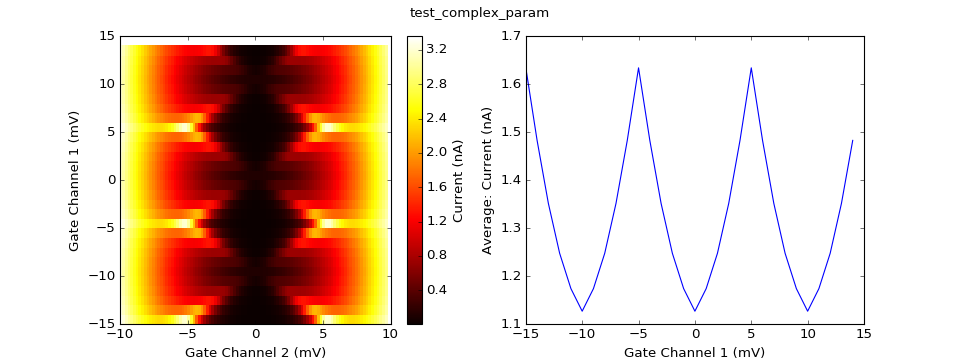

In [11]:
# An example of a parameter that returns several values of different dimension
# This produces the last two arrays from data3, but only takes the data once.
data4 = qc.Loop(c1[-15:15:1], 0.1).each(
    AverageAndRaw(meter.amplitude, c2[-10:10:0.2], 0.001)
).run(location='test_complex_param')

plot4 = qc.Plot(data4.amplitude, cmap=plt.cm.hot, subplots=(1,2), figsize=(12, 4.5))
plot4.add(data4.avg_amplitude, subplot=2)